# Dummy Particle Grouping (ZenML)

A minimal end-to-end example that mirrors the legacy synthetic grouping notebook:
- Build synthetic hit groups with three binary labels (energy / hit count / spread).
- Train the `GroupClassifier` via a ZenML pipeline.
- Reload artifacts and render quick diagnostics directly in the notebook.

In [1]:
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines import dummy_particle_grouping_optuna_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
run = dummy_particle_grouping_optuna_pipeline.with_options(enable_cache=False)(
    build_dummy_datamodule_params={
        'num_samples': 2048,   # dataset size
        'batch_size': 64,      # base batch size (search can override)
        'num_workers': 0,      # dataloader workers
    },
    run_dummy_hparam_search_params={
        'n_trials': 25,            # Optuna trials for the search step
        'max_epochs': 20,          # epochs per trial during search
        'limit_train_batches': 0.8,# fraction/int of train batches per trial
        'limit_val_batches': 1.0,  # fraction/int of val batches per trial
    },
    train_best_dummy_model_params={
        'max_epochs': 50,              # final training epochs cap
        'early_stopping': False,       # disable to force full max_epochs
        'early_stopping_patience': 6,  # used only if early_stopping=True
        'early_stopping_monitor': 'val_loss', # metric to watch if enabled
        'early_stopping_mode': 'min',  # direction for the monitor
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: dummy_particle_grouping_optuna_pipeline.
Caching is disabled by default for dummy_particle_grouping_optuna_pipeline.
Using user: default
Using stack: default
  deployer: default
  orchestrator: default
  artifact_store: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_dummy_datamodule has started.
Step build_dummy_datamodule has finished in 0.143s.
Step run_dummy_hparam_search has started.


[I 2025-12-01 06:49:05,101] A new study created in memory with name: no-name-a5a1d2a6-884e-418c-8b94-ddb8b9370b44
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[I 2025-12-01 06:49:26,427] Trial 0 finished with value: 0.9352078437805176 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.22166849052914667, 'lr': 0.00036195284278156076, 'weight_decay': 0.0008270641129120947}. Best is trial 0 with value: 0.9352078437805176.
[I 2025-12-01 06:49:45,116] Trial 1 finished with value: 0.8480032682418823 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.20617304415824123, 'lr': 0.0013762767901727357, 'weight_decay': 0.0005669087154374776}. Best is trial 0 with value: 0.9352078437805176.
[I 2025-12-01 06:50:02,337] Trial 2 finished with value: 0.9494703412055969 and parameters: {'batch_size': 32, 'hidden': 128, 'num_bloc

Step run_dummy_hparam_search has finished in 6m57s.
Step train_best_dummy_model has started.
Step train_best_dummy_model has finished in 50.671s.
Step collect_dummy_predictions has started.
Step collect_dummy_predictions has finished in 1.059s.
Pipeline run has finished in 7m50s.
Run name: dummy_particle_grouping_optuna_pipeline-2025_12_01-11_49_04_096442
Run status: completed


In [3]:
trained_module = load_step_output(run, "train_best_dummy_model")
datamodule = load_step_output(run, "build_dummy_datamodule")
predictions = load_step_output(run, "collect_dummy_predictions", index=0)
targets = load_step_output(run, "collect_dummy_predictions", index=1)
best_params = load_step_output(run, "run_dummy_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")
print("Best params from Optuna:", best_params)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))


Loaded module on cpu; validation samples: 409
Best params from Optuna: {'batch_size': 32, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.24704912368790258, 'lr': 0.0006085051822731165, 'weight_decay': 0.00016527478745843188, 'best_score': 0.9523227214813232, 'n_trials': 25} {'batch_size': 32, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.24704912368790258, 'lr': 0.0006085051822731165, 'weight_decay': 0.00016527478745843188, 'best_score': 0.9523227214813232, 'n_trials': 25}
Epochs actually run: 51 51


In [4]:
class_names = [
    "energy_high",
    "energy_low",
    "nhits_high",
    "nhits_low",
    "spread_high",
    "spread_low",
]
print("Class names (index-aligned):", class_names)

Class names (index-aligned): ['energy_high', 'energy_low', 'nhits_high', 'nhits_low', 'spread_high', 'spread_low'] ['energy_high', 'energy_low', 'nhits_high', 'nhits_low', 'spread_high', 'spread_low']


In [5]:
import numpy as np
from pioneerml.data.datasets.graph_group import GraphRecord

# Tensors -> numpy
preds_np = predictions.detach().cpu().numpy() if hasattr(predictions, "detach") else np.asarray(predictions)
truths_np = targets.detach().cpu().numpy() if hasattr(targets, "detach") else np.asarray(targets)

# Recover the original GraphRecord objects for the validation split
val_ds = datamodule.val_dataset or datamodule.train_dataset
if val_ds is None:
    raise RuntimeError("No validation or training dataset available to extract parameters.")

if hasattr(val_ds, "dataset") and hasattr(val_ds, "indices"):
    base_ds = val_ds.dataset
    indices = val_ds.indices
    records = [base_ds.items[i] for i in indices]
elif hasattr(val_ds, "items"):
    records = list(val_ds.items)
else:
    # Fallback: assume each sample carries the raw record on `_raw`
    records = [getattr(sample, "_raw", None) for sample in val_ds]

def extract_parameters(record: GraphRecord):
    coord = np.asarray(record.coord)
    energy = np.asarray(record.energy)
    return float(energy.mean()), float(len(coord)), float(coord.std())

params = np.array([extract_parameters(r) for r in records])
preds_binary = (preds_np > 0.5).astype(np.float32)


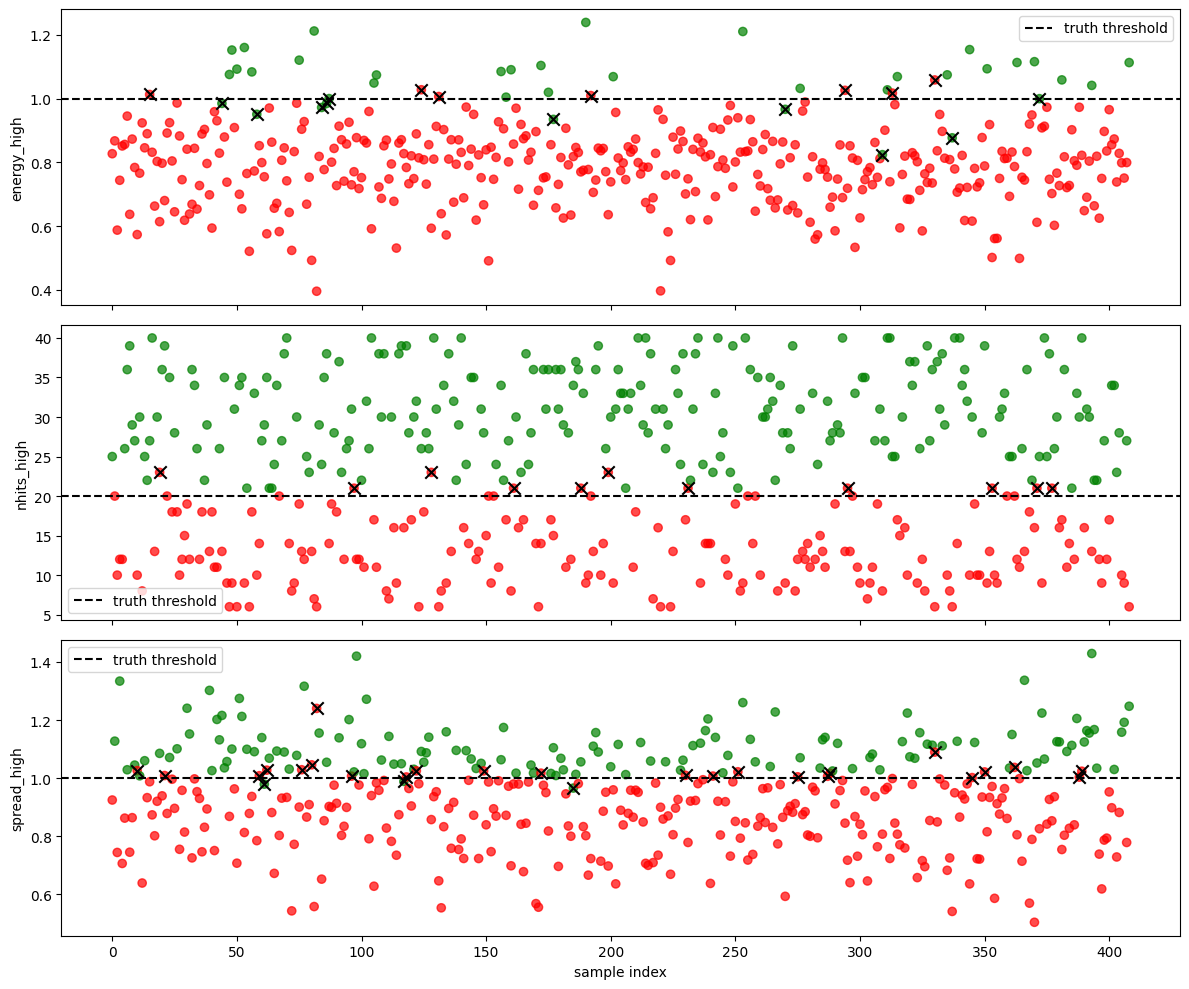

In [6]:
import matplotlib.pyplot as plt

high_class_indices = [0, 2, 4]
high_class_names = ["energy_high", "nhits_high", "spread_high"]
thresholds = [1.0, 20.0, 1.0]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for i, ax in enumerate(axes):
    cls_idx = high_class_indices[i]
    y_param = params[:, i]
    pred = preds_binary[:, cls_idx]
    truth = truths_np[:, cls_idx]

    colors = ["red" if p == 0 else "green" for p in pred]
    ax.scatter(np.arange(len(y_param)), y_param, c=colors, alpha=0.7)
    ax.axhline(thresholds[i], color="black", linestyle="--", label="truth threshold")

    wrong = pred != truth
    ax.scatter(np.where(wrong)[0], y_param[wrong], marker="x", s=80, c="black")

    ax.set_ylabel(high_class_names[i])
    ax.legend()

axes[-1].set_xlabel("sample index")
plt.tight_layout()
plt.show()


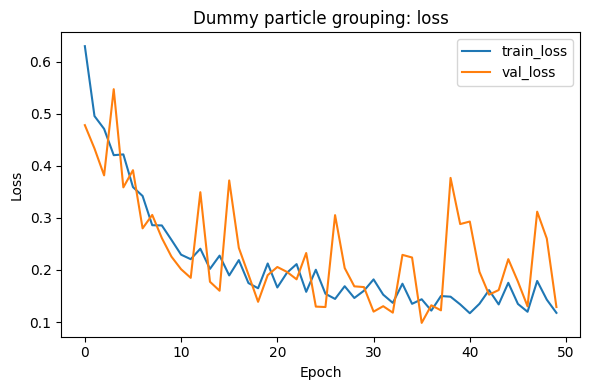

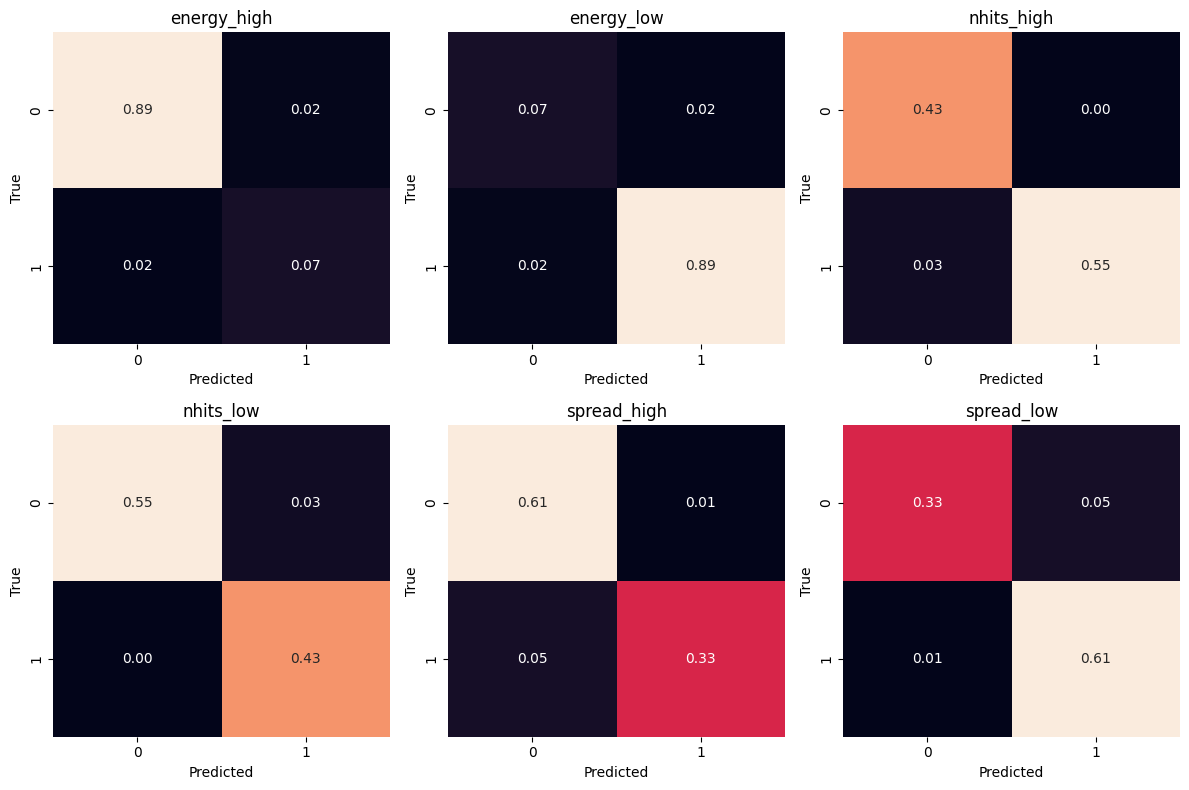

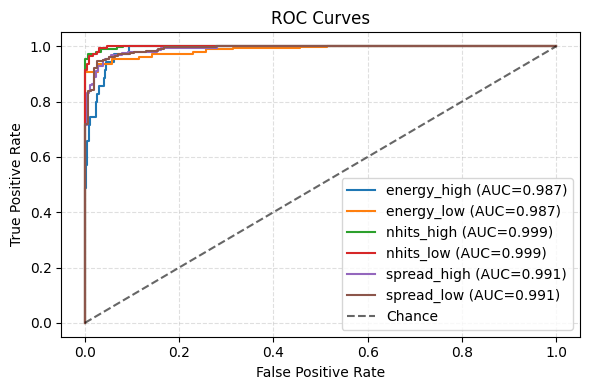

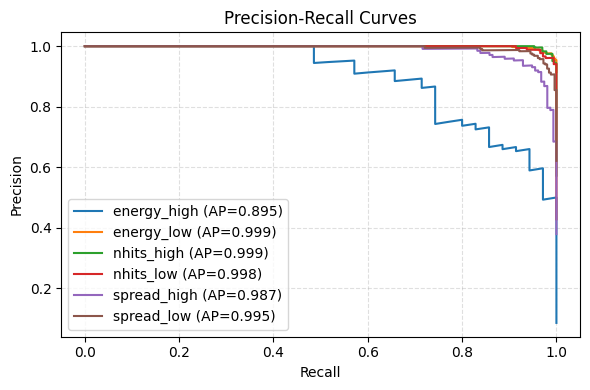

In [7]:
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

plot_loss_curves(trained_module, title="Dummy particle grouping: loss", show=True)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)
plot_roc_curves(predictions, targets, class_names=class_names, show=True)
plot_precision_recall_curves(predictions, targets, class_names=class_names, show=True)